In [1]:
import os 
import sys 
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split, Subset

In [2]:
import matplotlib.pyplot as plt
from init_model_lstm import DeconvolutionModel

In [3]:
def add_gaussian_noise(tensor, device, mean=0, stddev=0.1):
    noise=(torch.randn_like(tensor)*stddev+mean).to(device)
    noised_tensor=tensor+noise
    return noised_tensor

In [4]:
device = (
        "cuda"
        if torch.cuda.is_available()
        else "mps"
        if torch.backends.mps.is_available()
        else "cpu"
    )
print(f"Using {device} device")

n = 70000
known_freqs_file = f'known_freqs_{n}.npy'
snv_freqs_file = f'snv_freqs_{n}.npy'

Using mps device


In [5]:
snv_freqs=np.load(snv_freqs_file).astype('float32')
known_freqs=np.load(known_freqs_file).astype('float32')

snv_freqs=torch.from_numpy(snv_freqs).to(device)
known_freqs=torch.from_numpy(known_freqs).to(device)

In [6]:
snv_freqs_splits=torch.split(snv_freqs, [10000, 10000, 10000,10000, 10000, 10000, 10000])
known_freqs_splits=torch.split(known_freqs, [10000, 10000, 10000,10000, 10000, 10000, 10000])

Using mps device
Epoch 1, Train loss: 0.0071597964, Validation loss: 0.0066729988, LR: 0.0001
Epoch 2, Train loss: 0.0063867158, Validation loss: 0.0062565760, LR: 0.0001
Epoch 3, Train loss: 0.0060818139, Validation loss: 0.0060446976, LR: 0.0001
Epoch 4, Train loss: 0.0059114454, Validation loss: 0.0059155438, LR: 0.0001
Epoch 5, Train loss: 0.0058003667, Validation loss: 0.0058241730, LR: 0.0001
Epoch 6, Train loss: 0.0057223613, Validation loss: 0.0057613902, LR: 0.0001
Epoch 7, Train loss: 0.0056659513, Validation loss: 0.0057072858, LR: 0.0001
Epoch 8, Train loss: 0.0056202202, Validation loss: 0.0056628941, LR: 0.0001
Epoch 9, Train loss: 0.0055833321, Validation loss: 0.0056272617, LR: 0.0001
Epoch 10, Train loss: 0.0055532290, Validation loss: 0.0055998625, LR: 0.0001
Epoch 11, Train loss: 0.0055285574, Validation loss: 0.0055779978, LR: 0.0001
Epoch 12, Train loss: 0.0055067299, Validation loss: 0.0055573266, LR: 0.0001
Epoch 13, Train loss: 0.0054882604, Validation loss: 0.0

KeyboardInterrupt: 

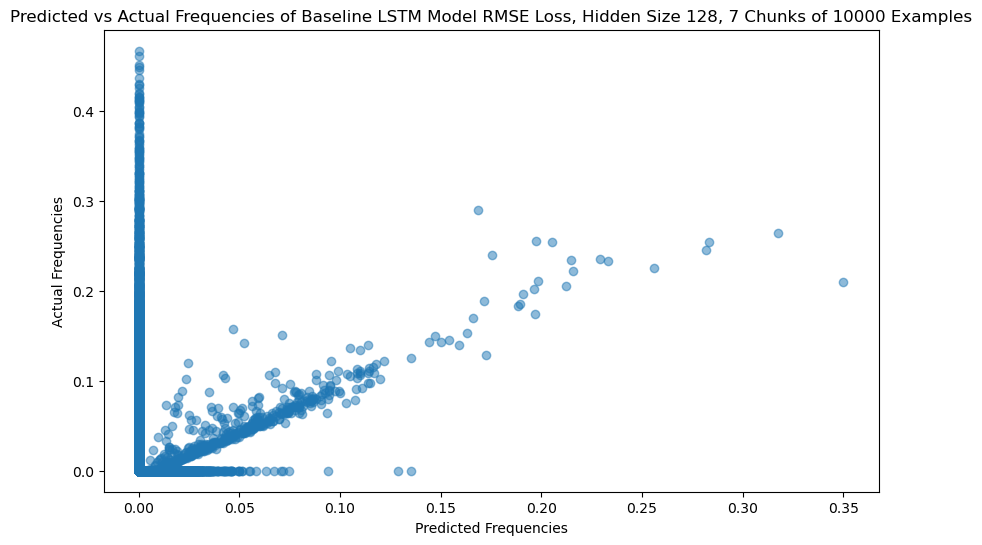

In [14]:
hidden_size=128
num_layers=1
model = DeconvolutionModel(input_size, hidden_size, output_size, num_layers, device)

for i in range(7):
    batch_size_=snv_freqs_splits[0].shape[0]
    seq_len=1
    input_size = snv_freqs_splits[0].shape[1]
    output_size = known_freqs_splits[0].shape[1]

    snv_freqs=snv_freqs_splits[i].view(batch_size_, seq_len, input_size)
    
    dataset=TensorDataset(snv_freqs, known_freqs_splits[i])

    train_dataset, validation_dataset, test_dataset = random_split(
        dataset, [0.8, 0.1, 0.1]
    )

    batch_size = 64  # Arbitrarily chosen
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model.fit(train_loader, validation_loader, epochs=10000)

    # Evaluate the model
    model.evaluate(validation_loader)

    # Predict using he model
    predictions, actuals = model.predict(test_loader)

    plt.figure(figsize=(10, 6))
    plt.scatter(predictions.flatten(), actuals.flatten(), alpha=0.5)
    plt.xlabel('Predicted Frequencies')
    plt.ylabel('Actual Frequencies')
    plt.title(f'Predicted vs Actual Frequencies of Baseline LSTM Model RMSE Loss, Hidden Size 128, 7 Chunks of 10000 Examples')
    plt.savefig(f'Predicted vs Actual Hidden Size 128, 7 Chunks of 10000 Examples, Plateau LR, Split {i+1}.png')

    torch.save(model.model.state_dict(), 'model_weights.pth')
    torch.save(model.optimizer.state_dict(), 'optimizer_state.pth')

    # Load model and optimizer state for next chunk
    model.model.load_state_dict(torch.load('model_weights.pth'))
    model.optimizer.load_state_dict(torch.load('optimizer_state.pth'))


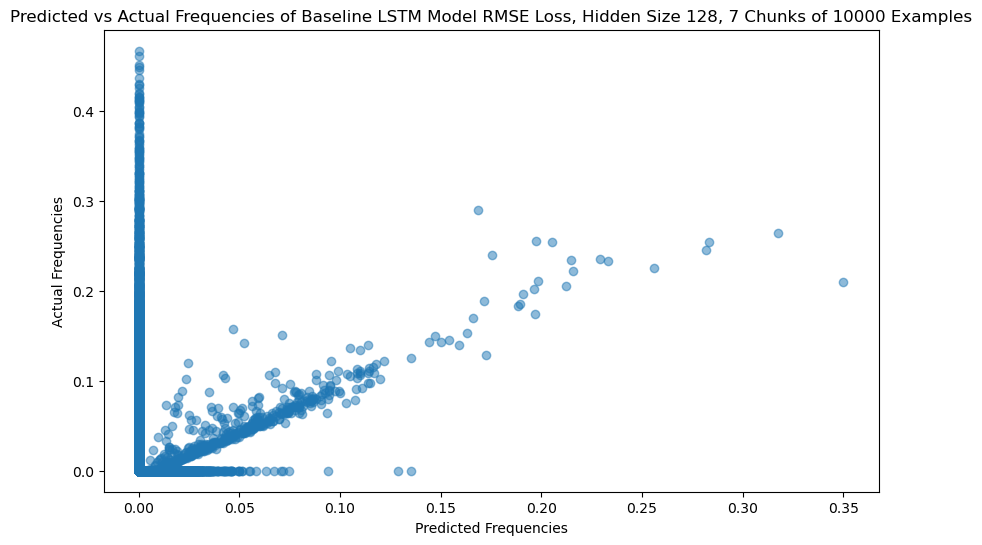

In [15]:
plt.figure(figsize=(10, 6))
plt.scatter(predictions.flatten(), actuals.flatten(), alpha=0.5)
plt.xlabel('Predicted Frequencies')
plt.ylabel('Actual Frequencies')
plt.title(f'Predicted vs Actual Frequencies of Baseline LSTM Model RMSE Loss, Hidden Size 128, 7 Chunks of 10000 Examples')
plt.show()

In [12]:
snv_freqs=snv_freqs_splits[1].view(batch_size, seq_len, input_size)

In [13]:
dataset=TensorDataset(snv_freqs, known_freqs_splits[i])

train_dataset, validation_dataset, test_dataset = random_split(
        dataset, [0.8, 0.1, 0.1]
    )

batch_size = 64  # Arbitrarily chosen
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model.fit(train_loader, validation_loader, epochs=10000)

# Evaluate the model
model.evaluate(validation_loader)

# Predict using he model
predictions, actuals = model.predict(test_loader)

Epoch 1, Train loss: 0.0054292479, Validation loss: 0.0054231915, LR: 1e-05
Epoch 2, Train loss: 0.0054276782, Validation loss: 0.0054227132, LR: 1e-05
Epoch 3, Train loss: 0.0054277224, Validation loss: 0.0054223704, LR: 1e-05
Epoch 4, Train loss: 0.0054261585, Validation loss: 0.0054221908, LR: 1e-05
Epoch 5, Train loss: 0.0054270548, Validation loss: 0.0054219839, LR: 1e-05
Epoch 6, Train loss: 0.0054262442, Validation loss: 0.0054218658, LR: 1e-05
Epoch 7, Train loss: 0.0054255664, Validation loss: 0.0054219037, LR: 1e-05
Epoch 8, Train loss: 0.0054251463, Validation loss: 0.0054216722, LR: 1e-05
Epoch 9, Train loss: 0.0054249536, Validation loss: 0.0054216609, LR: 1e-05
Epoch 10, Train loss: 0.0054257624, Validation loss: 0.0054215424, LR: 1e-05
Epoch 11, Train loss: 0.0054250293, Validation loss: 0.0054215683, LR: 1e-05
Epoch 12, Train loss: 0.0054249428, Validation loss: 0.0054215165, LR: 1e-05
Epoch 13, Train loss: 0.0054243683, Validation loss: 0.0054214957, LR: 1e-05
Epoch 14

KeyboardInterrupt: 

In [27]:
dataset_1 = TensorDataset(snv_freqs_splits[0], known_freqs_splits[0])

total_size = len(dataset_1)
test_size = total_size // 10  # 10% for test
validation_size = total_size // 10  # 10% for validation
train_size = total_size - test_size - validation_size  # 80% train

train_dataset, validation_dataset, test_dataset = random_split(
        dataset_1, [train_size, validation_size, test_size]
    )

In [9]:
batch_size = 64  # Arbitrarily chosen
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [12]:
hidden_size=126
num_layers=1
model = DeconvolutionModel(input_size, hidden_size, output_size, num_layers, device)

Using mps device


In [13]:
model.optimizer()

TypeError: 'Adam' object is not callable

In [ ]:
model.fit(train_loader, validation_loader, epochs=10000)

# Evaluate the model
model.evaluate(validation_loader)

# Predict using he model
predictions, actuals = model.predict(test_loader)

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(predictions.flatten(), actuals.flatten(), alpha=0.5)
plt.xlabel('Predicted Frequencies')
plt.ylabel('Actual Frequencies')
plt.title(f'Predicted vs Actual Frequencies of Baseline LSTM Model RMSE Loss, Hidden Size 256 Variable LR, 250 Patience, More Samples')
plt.savefig(f'Predicted vs Actual Split [i+1]')

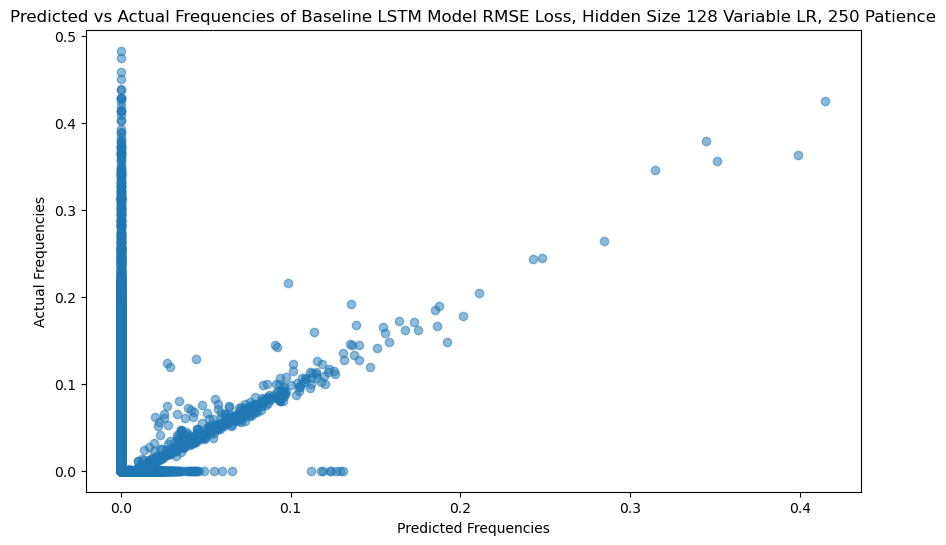

In [13]:
plt.figure(figsize=(10, 6))
plt.scatter(predictions.flatten(), actuals.flatten(), alpha=0.5)
plt.xlabel('Predicted Frequencies')
plt.ylabel('Actual Frequencies')
plt.title(f'Predicted vs Actual Frequencies of Baseline LSTM Model RMSE Loss, Hidden Size 128 Variable LR, 250 Patience')
plt.show()

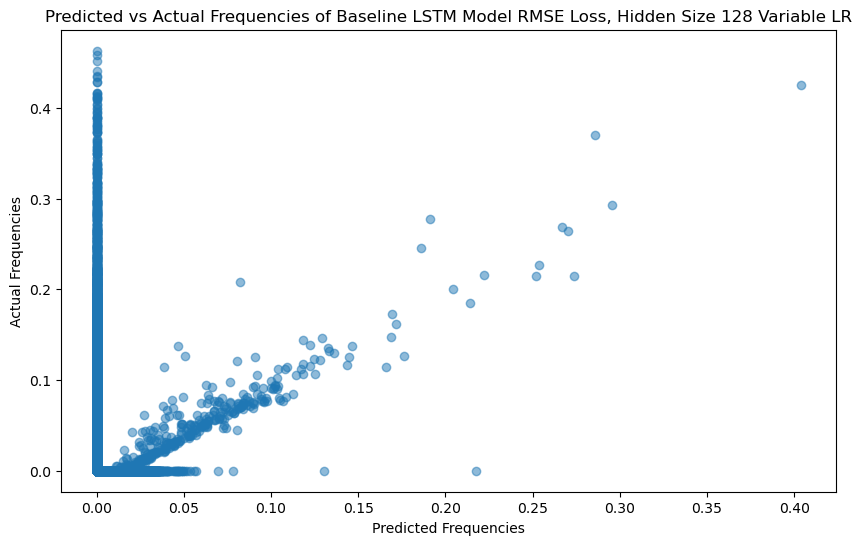

In [12]:
plt.figure(figsize=(10, 6))
plt.scatter(predictions.flatten(), actuals.flatten(), alpha=0.5)
plt.xlabel('Predicted Frequencies')
plt.ylabel('Actual Frequencies')
plt.title(f'Predicted vs Actual Frequencies of Baseline LSTM Model RMSE Loss, Hidden Size 128 Variable LR')
plt.show()

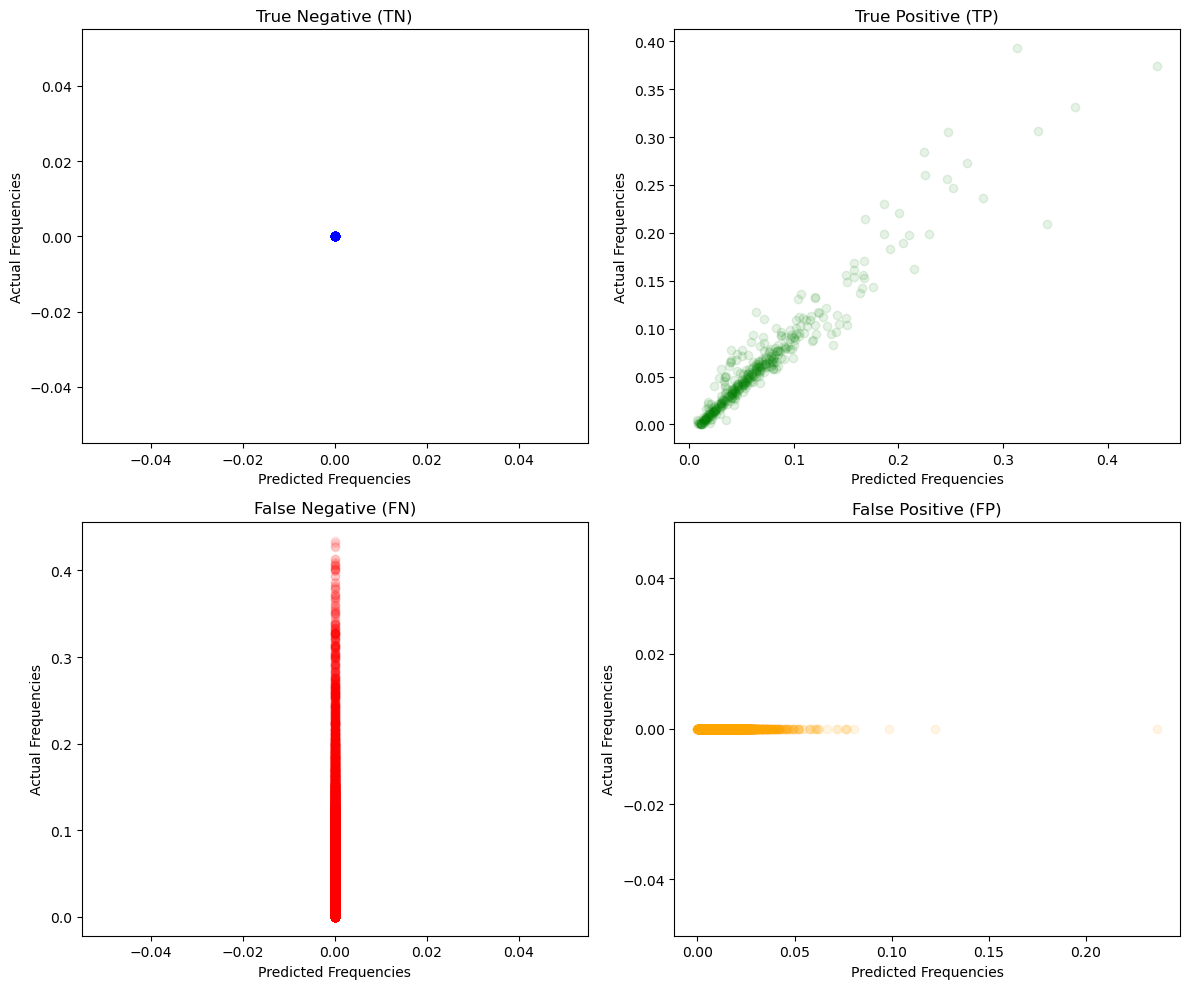

Accuracy: 0.97273838
Precision: 0.00416109
Recall: 0.02228756
F1 Score: 0.00701287


In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.stats import gaussian_kde

y_pred=predictions.flatten()
y_true= actuals.flatten()

tn_mask = (y_true == 0) & (y_pred == 0)
tp_mask = (y_true != 0) & (y_pred != 0)
fn_mask = (y_true != 0) & (y_pred == 0)
fp_mask = (y_true == 0) & (y_pred != 0)

# Scatter plot
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Scatter plot for True Negatives (TN)
axs[0, 0].scatter(y_pred[tn_mask], y_true[tn_mask], color='blue', alpha=0.1)
axs[0, 0].set_title('True Negative (TN)')
axs[0, 0].set_xlabel('Predicted Frequencies')
axs[0, 0].set_ylabel('Actual Frequencies')

# Scatter plot for True Positives (TP)
axs[0, 1].scatter(y_pred[tp_mask], y_true[tp_mask], color='green', alpha=0.1)
axs[0, 1].set_title('True Positive (TP)')
axs[0, 1].set_xlabel('Predicted Frequencies')
axs[0, 1].set_ylabel('Actual Frequencies')

# Scatter plot for False Negatives (FN)
axs[1, 0].scatter(y_pred[fn_mask], y_true[fn_mask], color='red', alpha=0.1)
axs[1, 0].set_title('False Negative (FN)')
axs[1, 0].set_xlabel('Predicted Frequencies')
axs[1, 0].set_ylabel('Actual Frequencies')

# Scatter plot for False Positives (FP)
axs[1, 1].scatter(y_pred[fp_mask], y_true[fp_mask], color='orange', alpha=0.1)
axs[1, 1].set_title('False Positive (FP)')
axs[1, 1].set_xlabel('Predicted Frequencies')
axs[1, 1].set_ylabel('Actual Frequencies')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

y_true_binary = (y_true != 0).astype(int)
y_pred_binary = (y_pred != 0).astype(int)

accuracy = accuracy_score(y_true_binary, y_pred_binary)
precision = precision_score(y_true_binary, y_pred_binary)
recall = recall_score(y_true_binary, y_pred_binary)
f1 = f1_score(y_true_binary, y_pred_binary)

# Print out the metrics using f-strings
print(f"Accuracy: {accuracy:.8f}")
print(f"Precision: {precision:.8f}")
print(f"Recall: {recall:.8f}")
print(f"F1 Score: {f1:.8f}")